# COGS 108 - Final Project 

# Overview

TBD

# Names

- Ankur Gupta
- Aditya Sampath
- Pedro Talancon
- Koodrut Panesar

# Group Members IDs

- A13877512
- A13441492
- A14400378
- A13561263

# Research Question

Does the average income and/or density of liquor-selling businesses in a neighborhood influence the amount of DUI tickets given in the area? Which one has a stronger correlation to DUI rates?

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


Yes, the income has a negative correlation and the density of liquor-selling businesses have a positive correlation, with the latter having a stronger correlation, to the DUI rates of a neighborhood. 

Since DUI rates of a neighborhood would be more dependent on the amount of people drinking and driving in the vicinity, areas with more bars, clubs, or restaurants (all which have lots of intoxicated people) would likely be the more correlated factor to DUI rates. “Nicer”, i.e. richer, neighborhoods are usually thought to be quiet and to have lower crime rates, thus the DUI rates in higher income neighborhoods is low, however the sheer amount of drunk people in areas like PB or gaslamp must have a higher influence on DUI rates. 


# Dataset(s)

Name: SDPublicCrimeData112019.txt

Description: All crimes documented in the last 180 days in San Diego. We are interested in the CM_LEGEND (only the DUI from the column), and the respective ZipCodes

Link: https://www.sandag.org/index.asp?classid=14&subclassid=21&projectid=446&fuseaction=projects.detail
Number of observations: 63806 entries 

Columns: CM_LEGEND, agency, Charge_Description_Orig, activityDate, BLOCK_ADDRESS, ZipCode, community 
    
Name: zip_pop.csv

Description: population per zipcode. We are only interested in the zip codes of the greater San Diego region

Number of observations: 33092 entries 

Columns: zip code and population of that zip code 

Link: 2010 Census data from COGS108 Fall'19 Assignment 3 

!!!NEEDS TO BE COMPLETED!!!

Name: zip_income.csv

Description: 

Number of observations: 

Columns: 

Link: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk

Name: ABC_Licenses.csv

Description: All businesses that own Alcoholic Beverage Licenses in San Diego 

Number of observations: 9737 entries

Columns: Lic_type, Lic_No, Lic_App, Status, Iss_Date, Exp_Date, Master, Term, GeoCode,  Name, Site_Addr1, Site_Addr2, Site_City, Site_State, Site_Zip, DBA_Name, Site_Cnty, Site_Tract, POINT_X, POINT_Y 

Link: https://hub.arcgis.com/datasets/6b6a0fe71f3f44b8b80f71151ae40de6_0/data?geometry=-118.474%2C32.196%2C-114.970%2C33.808 

# Setup

In [1]:
# Imports 
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest



# Data Cleaning

Import the 4 data sets into pandas dataframes

In [2]:
crime_df = pd.read_csv('SDPublicCrimeData112019.txt')
zip_df = pd.read_csv('zip_pop.csv')
income_df = pd.read_csv('zip_income.csv')
liquor_stores_df = pd.read_csv('ABC_Licenses.csv')

liquor_stores_df: keep name, status, and zip 
    1. Check that they’re all either 5 or 10 digits to make sure they’re all valid
    2. Drop the last 4 digits of the zip code if its a 9 digit zip code  
    3. Convert zips to floats

In [3]:
liquor_stores_df = liquor_stores_df[['Status', 'DBA_Name', 'Site_ZIP']]
liquor_stores_df = liquor_stores_df[liquor_stores_df['Status'] == 'ACTIVE']
liquor_stores_df.columns = ['Status', 'Name', 'zip']

In [4]:
for zip_code in liquor_stores_df['zip']:
    if len(zip_code) != 5 and len(zip_code) != 10:
        print(zip_code)

In [5]:
liquor_stores_df['zip'] = liquor_stores_df['zip'].str[:5]
liquor_stores_df['zip'] = liquor_stores_df['zip'].astype(float)

income_df: keep zip, median income
    1. Remove all rows that lack data or are not an int 
    2. Remove all other columns as they’re not necessary for our analysis 
    3. Convert appropriate columns to floats 

In [6]:
income_df = income_df[['GEO.id2', 'HC03_EST_VC02', 'HC03_MOE_VC02']]
income_df.columns = ['zip', 'median_income', 'median_income_moe']

In [7]:
income_df = income_df.drop(income_df[income_df['median_income_moe'] == '**'].index)
income_df = income_df.drop(income_df[income_df['median_income_moe'] == '***'].index)
income_df = income_df.drop(income_df.index[0])
income_df = income_df[['zip', 'median_income']]

In [8]:
income_df['zip'] = income_df['zip'].astype(float)
income_df['median_income'] = income_df['median_income'].astype(float)

crime_df: keep only the rows whose CM_LEGEND is DUI, drop all other columns  
    1. First checked to see if there were variations of ‘DUI’ such as ‘driving under the influence’, etc. 
    2. Drop entries that didn’t have a valid zip code (e.g. Nan)
    3. Drop activityDate, BLOCK_ADDRESS, community due to the Safe Harbor Method 
    4. Drop agency because its not needed for our analysis 
    5. Rename columns to easier names 


In [9]:
crime_df.CM_LEGEND.unique()

array(['MOTOR VEHICLE THEFT', 'BURGLARY', 'THEFT/LARCENY', 'ASSAULT',
       'ROBBERY', 'VANDALISM', 'DRUGS/ALCOHOL VIOLATIONS', 'WEAPONS',
       'DUI', 'FRAUD', 'VEHICLE BREAK-IN/THEFT', 'SEX CRIMES', 'ARSON',
       'HOMICIDE'], dtype=object)

In [10]:
crime_df = crime_df[crime_df['CM_LEGEND']=='DUI']

In [11]:
crime_df["ZipCode"].unique()

array([91911., 92024., 91910., 91913., 91915., 92064., 92114., 92009.,
       92109., 92118., 92075., 92083., 92008., 91941., 92027., 92084.,
       92025., 92111., 92103., 92078., 91932., 92010., 92069., 92123.,
       91942., 91950., 92110., 92065., 92102., 91914., 92126., 92081.,
       92011., 92056., 91901.,    nan, 92117., 92120., 92054., 92105.,
       92113., 20650., 92154., 92057., 92029., 92116., 92101., 92058.,
       92026., 92130., 92173., 92139., 92124., 92107., 92121., 92104.,
       92106., 92115., 92108., 92128., 92071., 92131., 92037., 92129.,
       92122., 92100., 92182., 92021., 92007., 92127., 92020., 92014.,
       92140., 92019., 91978., 91951., 91945., 92155., 92040., 91977.,
       91902., 92003., 92119., 92028., 90284., 92145.])

In [12]:
assert(sum(np.isnan(crime_df["ZipCode"].unique())) == 1)

In [13]:
crime_df = crime_df.dropna(subset=['ZipCode'])

In [14]:
assert(sum(np.isnan(crime_df["ZipCode"].unique())) == 0)

In [15]:
crime_df.head(10)

,CM_LEGEND,agency,Charge_Description_Orig,activityDate,BLOCK_ADDRESS,ZipCode,community
27,DUI,CHULA VISTA,DUI ALC/0.08 PERCENT (M),7/27/2019 2:56:25,400 E BLOCK PALOMAR STREET,91911.0,CHULA VISTA
41,DUI,SHERIFF,DUI ALCOHOL (M),10/3/2019 23:37:00,GLASGOW AVENUE & LIVERPOOL DRIVE,92024.0,ENCINITAS
68,DUI,CHULA VISTA,DUI ALC/0.08 PERCENT (M),8/12/2019 1:06:00,300 BLOCK 04TH AVENUE,91910.0,CHULA VISTA
86,DUI,CHULA VISTA,DUI ALCOHOL (M),8/15/2019 12:43:00,600 BLOCK BROADWAY,91910.0,CHULA VISTA
102,DUI,CHULA VISTA,DUI ALC/0.08 PERCENT (M),8/3/2019 5:05:06,SANTA VENETIAST & WINDCHIME AVENUE,91913.0,NaN
103,DUI,CHULA VISTA,DUI ALCOHOL (M),8/4/2019 8:15:00,LA MEDIA ROAD & E PALOMAR STREET,91915.0,CHULA VISTA
120,DUI,SHERIFF,DUI ALCOHOL (M),7/29/2019 20:07:00,13500 BLOCK KENTFIELD DRIVE,92064.0,POWAY
155,DUI,CHULA VISTA,DUI ALCOHOL (M),9/7/2019 1:06:00,0 BLOCK J STREET ( 200 BLOCK ),91910.0,NaN
156,DUI,CHULA VISTA,DUI ALC/0.08 PERCENT (M),9/8/2019 0:56:00,PASEO ENTRADA & PASEO LADERA,91910.0,CHULA VISTA
157,DUI,CHULA VISTA,DUI ALC/0.08 PERCENT (M),9/7/2019 22:55:00,BONITA ROAD & PLAZA BONITA ROAD,91910.0,CHULA VISTA


In [16]:
crime_df = crime_df.drop(['activityDate', 'BLOCK_ADDRESS', 'community'], axis = 1)

In [17]:
crime_df = crime_df.drop(['agency'], axis = 1)

In [18]:
crime_df.columns = ['crime', 'charge_description', 'zip']

income_df: 
1. Check for any invalid / outlying zip codes: Dropped 20650 zip code because it was in maryland - it had 3 DUI points with that zip and after looking at the 3 entries, they looked like duplicates of each other

In [19]:
print(len(crime_df["zip"].unique()))
print(crime_df["zip"].unique())
print(crime_df[crime_df["zip"] == 20650])

85
[91911. 92024. 91910. 91913. 91915. 92064. 92114. 92009. 92109. 92118.
 92075. 92083. 92008. 91941. 92027. 92084. 92025. 92111. 92103. 92078.
 91932. 92010. 92069. 92123. 91942. 91950. 92110. 92065. 92102. 91914.
 92126. 92081. 92011. 92056. 91901. 92117. 92120. 92054. 92105. 92113.
 20650. 92154. 92057. 92029. 92116. 92101. 92058. 92026. 92130. 92173.
 92139. 92124. 92107. 92121. 92104. 92106. 92115. 92108. 92128. 92071.
 92131. 92037. 92129. 92122. 92100. 92182. 92021. 92007. 92127. 92020.
 92014. 92140. 92019. 91978. 91951. 91945. 92155. 92040. 91977. 91902.
 92003. 92119. 92028. 90284. 92145.]
      crime charge_description      zip
1968    DUI    DUI ALCOHOL (M)  20650.0
2108    DUI    DUI ALCOHOL (M)  20650.0
10001   DUI    DUI ALCOHOL (M)  20650.0


In [20]:
crime_df = crime_df.drop(crime_df[crime_df["zip"] == 20650].index)

In [21]:
assert(len(crime_df[crime_df["zip"] == 20650]) == 0)

Merge the 4 df’s, dropping any columns that don’t have all 4 values (crime, zip, population, or median income) appropriately filled out - always do a left merge
1. Merge crime with population 
2. Zip codes 92100, 92182, 91951, and 90284 were dropped as their 2010 census information wasn’t collected 
3. Merge income with cumalative_df 
4. Zip codes 92140 and 92155 were dropped because they’re military bases thus lack an average income
5. Merge liquor_stores with cumulative_df 
6. Zip code 92145 was not dropped even though it was a military base with no liquor stores 
7. Make sure each zip code is only once in each dataframe 

In [22]:
cumulative_df = pd.merge(crime_df, zip_df, on='zip', how='left')

In [23]:
cumulative_df[cumulative_df['population'].isnull() == True]

,crime,charge_description,zip,population
469,DUI,DUI ALC/0.08 PERCENT (M),92100.0,NaN
515,DUI,DUI ALC/0.08 PERCENT (M),92182.0,NaN
830,DUI,DUI ALCOHOL (M),91951.0,NaN
1561,DUI,DUI ALCOHOL (M),90284.0,NaN


In [24]:
cumulative_df = cumulative_df.drop(cumulative_df[cumulative_df["zip"] == 92100].index)
cumulative_df = cumulative_df.drop(cumulative_df[cumulative_df["zip"] == 92182].index)
cumulative_df = cumulative_df.drop(cumulative_df[cumulative_df["zip"] == 91951].index)
cumulative_df = cumulative_df.drop(cumulative_df[cumulative_df["zip"] == 90284].index)

In [25]:
assert(len(cumulative_df[cumulative_df["zip"] == 92100]) == 0)
assert(len(cumulative_df[cumulative_df["zip"] == 92182]) == 0)
assert(len(cumulative_df[cumulative_df["zip"] == 91951]) == 0)
assert(len(cumulative_df[cumulative_df["zip"] == 90284]) == 0)

In [26]:
cumulative_df = pd.merge(cumulative_df, income_df, on='zip', how='left')

In [27]:
cumulative_df[cumulative_df['median_income'].isnull() == True]

,crime,charge_description,zip,population,median_income
699,DUI,DUI ALCOHOL (M),92140.0,3435.0,NaN
1016,DUI,DUI ALCOHOL,92155.0,550.0,NaN
1993,DUI,USE WATERCRAFT WHILE UNDER INFLUENCE OF ALCOHO...,92155.0,550.0,NaN


In [28]:
cumulative_df = cumulative_df.drop(cumulative_df[cumulative_df["zip"] == 92140].index)
cumulative_df = cumulative_df.drop(cumulative_df[cumulative_df["zip"] == 92155].index)

In [29]:
assert(len(cumulative_df[cumulative_df["zip"] == 92140]) == 0)
assert(len(cumulative_df[cumulative_df["zip"] == 92155]) == 0)

In [30]:
unique_crime_zips = cumulative_df['zip']
liquor_zips = set(liquor_stores_df['zip'])
zips_with_no_liquor_stores = set()

for crime_zip in unique_crime_zips:
    if crime_zip not in liquor_zips:
        zips_with_no_liquor_stores.add(crime_zip)

print(zips_with_no_liquor_stores)

{92145.0}


In [31]:
len(cumulative_df['zip'].unique())

78

Create a dataframe that uses the analysis that we derive from the cumulative df
1. Make sure we have each zip code once in the final dataframe.
2. Add the median income for each zip code to each row
3. For each zip code in the final df, calculate the number of liquor stores divided by the population of that zip code. This yields liquor_store_density in each zip code.
4. For each zip code in the final df, calculate the number of DUIs in that zip code divided by the population of that zip code. This yields DUI_rate in each zip code. 

In [32]:
result_df = pd.DataFrame(columns=['zip','median_income','liquor_store_density','DUI_rate'])

In [33]:
all_zips = cumulative_df['zip'].unique()
result_df['zip'] = all_zips

In [34]:
for zip_code in all_zips:
    zip_income = income_df[income_df['zip'] == zip_code]['median_income'].values[0]
    result_df.loc[result_df['zip'] == zip_code, "median_income"] = zip_income

In [35]:
for zip_code in all_zips:
    num_stores_in_zip = liquor_stores_df[liquor_stores_df['zip'] == zip_code]['zip'].count()
    zip_pop = cumulative_df[cumulative_df['zip'] == zip_code].iloc[0]['population']
    density = num_stores_in_zip / zip_pop
    result_df.loc[result_df['zip'] == zip_code, "liquor_store_density"] = density

In [36]:
total_DUIs = 0
for zip_code in all_zips:
    num_DUIs_in_zip = cumulative_df[cumulative_df['zip'] == zip_code]['crime'].count()
    zip_pop = cumulative_df[cumulative_df['zip'] == zip_code].iloc[0]['population']
    
    total_DUIs += num_DUIs_in_zip
    DUI_rate = num_DUIs_in_zip / zip_pop
    result_df.loc[result_df['zip'] == zip_code, "DUI_rate"] = DUI_rate
result_df.head(5)

,zip,median_income,liquor_store_density,DUI_rate
0,91911.0,52274,0.00151809,0.00057832
1,92024.0,103417,0.00415301,0.00144541
2,91910.0,59371,0.00244057,0.000844305
3,91913.0,87440,0.000341705,0.000439335
4,91915.0,106452,0.00174379,0.000283872


In [37]:
assert(total_DUIs == cumulative_df.shape[0])

In [38]:
result_df["liquor_store_density"] = pd.to_numeric(result_df["liquor_store_density"])
result_df["DUI_rate"] = pd.to_numeric(result_df["DUI_rate"])

In [39]:
result_df.head(5)

,zip,median_income,liquor_store_density,DUI_rate
0,91911.0,52274,0.001518,0.000578
1,92024.0,103417,0.004153,0.001445
2,91910.0,59371,0.002441,0.000844
3,91913.0,87440,0.000342,0.000439
4,91915.0,106452,0.001744,0.000284


# Data Exploration

Let's get some basic visualizations: below we have 2 scatter matrices of the cumalative_df and result_df.  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c21bc84d0>,
      dtype=object)

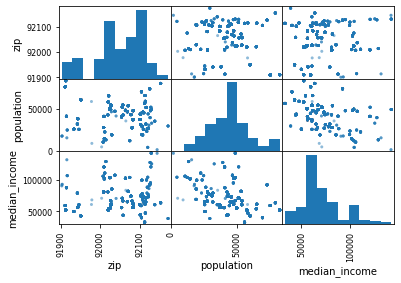

In [40]:
pd.plotting.scatter_matrix(cumulative_df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e256250>,
      dtype=object)

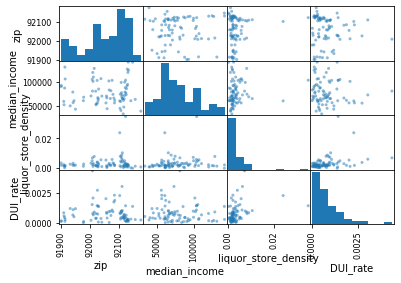

In [41]:
pd.plotting.scatter_matrix(result_df)


Next we have 3 charts to show the distributions of number of zio codes with a certain liquor store denstity, income, and DUI rate

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20c86c50>]],
      dtype=object)

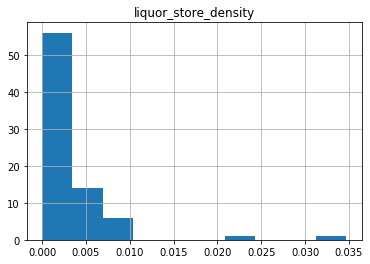

In [42]:
result_df.hist(column='liquor_store_density')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fe32a10>]],
      dtype=object)

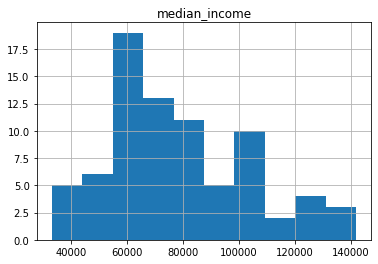

In [43]:
result_df.hist(column='median_income')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fd5ab50>]],
      dtype=object)

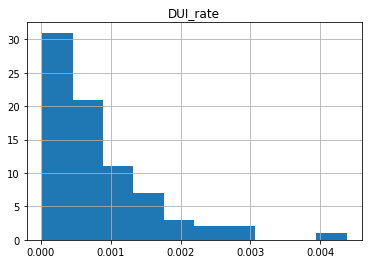

In [44]:
result_df.hist(column='DUI_rate')


Next is some basic statistical data on median_income, liquor_store_density, and DUI_rate. Values included are: median, mean, min, max, and range. 

In [45]:
income_dist = list(result_df["median_income"])
median_zip_income = np.median(income_dist)

print("Median", median_zip_income)
print("Mean", np.mean(income_dist))
print("Min", min(income_dist))
print("Max", max(income_dist))
print("Range", max(income_dist) - min(income_dist))
result_df[result_df["median_income"] == max(income_dist)]

Median 72208.5
Mean 78352.30769230769
Min 33125
Max 141926
Range 108801


,zip,median_income,liquor_store_density,DUI_rate
47,92130.0,141926,0.002227,0.000286


In [46]:
liquor_dist = list(result_df["liquor_store_density"])
median_liquor_density = np.median(liquor_dist)

print("Median", median_liquor_density)
print("Mean", np.mean(liquor_dist))
print("Min", min(liquor_dist))
print("Max", max(liquor_dist))
print("Range", max(liquor_dist) - min(liquor_dist))
result_df[result_df["liquor_store_density"] == max(liquor_dist)]

Median 0.002212094191613473
Mean 0.0035340265892453973
Min 0.0
Max 0.03469729600382867
Range 0.03469729600382867


,zip,median_income,liquor_store_density,DUI_rate
52,92121.0,103953,0.034697,0.001436


In [47]:
dui_dist = list(result_df["DUI_rate"])
print("Median", np.median(dui_dist))
print("Mean", np.mean(dui_dist))
print("Min", min(dui_dist))
print("Max", max(dui_dist))
print("Range", max(dui_dist) - min(dui_dist))
result_df[result_df["DUI_rate"] == max(dui_dist)]

Median 0.0006325487850205444
Mean 0.0008192115573141351
Min 1.713267543859649e-05
Max 0.004376288473362509
Range 0.004359155797923913


,zip,median_income,liquor_store_density,DUI_rate
12,92008.0,81073,0.00698,0.004376


# Data Analysis & Results

## Correlation

1. First we looked at correlations between DUI rate and liquor store density and median income
2. Use polyfit to determine the relationship between DUI rate and median income in terms of slope and offset
3. Use polyfit to determine the relationship between DUI rate and liquor store density in terms of slope and offset

In [48]:
result_df.corr()

,zip,median_income,liquor_store_density,DUI_rate
zip,1.000000,0.019662,0.147925,-0.025641
median_income,0.019662,1.000000,0.094757,-0.091820
liquor_store_density,0.147925,0.094757,1.000000,0.327651
DUI_rate,-0.025641,-0.091820,0.327651,1.000000


There is a positive correlation between liquor store density and DUI rate, and a weak negative correlation between DUI rate and median income of a zip code.

In [49]:
a_income, b_income = np.polyfit(result_df['median_income'], result_df['DUI_rate'], 1)

In [50]:
a_income, b_income

(-2.799312114338822e-09, 0.0010385441214236148)

In [51]:
a_density, b_density = np.polyfit(result_df['liquor_store_density'], result_df['DUI_rate'], 1)

In [52]:
a_density, b_density

(0.05286957980441174, 0.0006323690565231124)

In [53]:
pred_income = np.zeros(115)

for i in range(30, 145):
    pred_income[i - 30] = a_income * (i * 1000) + b_income

Scatter plots: 
1. Predicted DUI rates based off income using polyfit values
2. Plot it: y-axis being DUI rate and the x-axis being median zip code income
3. Predicted DUI rate based off liquor store density using polyfit values
4. Plot it: y-axis being DUI rate and the x-axis being liquor store density in a zip code

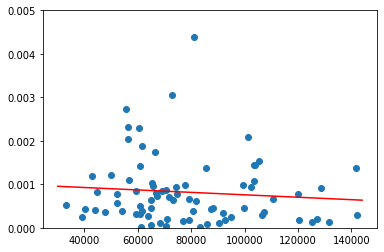

In [54]:
# TODO add axis labels
x_income = np.arange(30000, 145000, 1000)

# Limit the y-axis to positive values because there's no negative DUI rate
axes = plt.gca()
axes.set_ylim([0,0.005])

plt.scatter(result_df['median_income'], result_df['DUI_rate'])
plt.plot(x_income, pred_income, c='red')

f5 = plt.gcf()

In [55]:
pred_density = np.zeros(36)

for i in range(36):
    pred_density[i] = a_density * (i * 0.001) + b_density

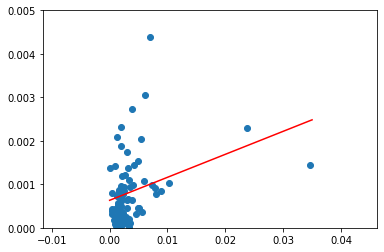

In [56]:
x_density = np.arange(0, 0.036, 0.001)

# Limit the y-axis to positive values because there's no negative DUI rate
axes = plt.gca()
axes.set_ylim([0, 0.005])

plt.scatter(result_df['liquor_store_density'], result_df['DUI_rate'])
plt.plot(x_density, pred_density, c='red')

f5 = plt.gcf()

## Significance

After looking at correlations between DUI rate and median income/liquor store density, we wanted to check if either factor was statistically signifcant in determining DUI rate. For the purposes of our analysis, we are using a *0.05 alpha significance threshold*.

1. Create brackets for both liquor store density and median income by splitting both at the median into two separate categories. As a result, we have two groups, low and high, for the median income and liquor store density.
2. For all zip codes in the result_df, classify each zip_code's median_income as RICH or POOR based on whether or not it's higher than the median zip_code income in San Diego. Add this income type-classification to the result_df.
3. For all zip codes in the result_df, classify each zip_code's liquor store density as HIGH or LOW based on whether or not it's higher than the median zip_code liquor story density in San Diego. Add this density type-classification to the result_df.

In [57]:
result_df["income_type"] = ""
result_df["density_type"] = ""

In [58]:
result_df.head(5)

,zip,median_income,liquor_store_density,DUI_rate,income_type,density_type
0,91911.0,52274,0.001518,0.000578,,
1,92024.0,103417,0.004153,0.001445,,
2,91910.0,59371,0.002441,0.000844,,
3,91913.0,87440,0.000342,0.000439,,
4,91915.0,106452,0.001744,0.000284,,


In [59]:
result_zips = result_df['zip'].unique()

In [60]:
for zip_code in result_zips:
    current_zip = result_df[result_df['zip'] == zip_code]
    income = current_zip['median_income'].values[0]
    income_type = ''
    
    if income > median_zip_income:
        income_type = 'RICH'
    else:
        income_type = 'POOR'
    
    result_df.loc[result_df['zip'] == zip_code, "income_type"] = income_type

In [61]:
for zip_code in result_zips:
    current_zip = result_df[result_df['zip'] == zip_code]
    density = current_zip['liquor_store_density'].values[0]
    density_type = ''
    
    if density > median_liquor_density:
        density_type = 'HIGH'
    else:
        density_type = 'LOW'
    
    result_df.loc[result_df['zip'] == zip_code, "density_type"] = density_type

result_df.head(5)

,zip,median_income,liquor_store_density,DUI_rate,income_type,density_type
0,91911.0,52274,0.001518,0.000578,POOR,LOW
1,92024.0,103417,0.004153,0.001445,RICH,HIGH
2,91910.0,59371,0.002441,0.000844,POOR,HIGH
3,91913.0,87440,0.000342,0.000439,RICH,LOW
4,91915.0,106452,0.001744,0.000284,RICH,LOW


Get DUI_rates for all zip_codes, grouped by income type.

In [62]:
income_poor = result_df[result_df['income_type'] == 'POOR']['DUI_rate'].values
income_rich = result_df[result_df['income_type'] == 'RICH']['DUI_rate'].values

Run a t-test on the DUI rates when separated into the income types.

In [63]:
t_val_income, p_val_income = ttest_ind(income_poor, income_rich)
t_val_income, p_val_income

(0.19465469942537508, 0.8461826866567435)

In [64]:
if p_val_income < 0.05:
    print("There was a significant difference")
else:
    print("There was not a significant difference.")

There was not a significant difference.


Get DUI_rates for all zip_codes, grouped by liquor store density classification.

In [65]:
density_high = result_df[result_df['density_type'] == 'HIGH']['DUI_rate'].values
density_low = result_df[result_df['density_type'] == 'LOW']['DUI_rate'].values

Run a t-test on the DUI rates when separated into the density types.

In [66]:
t_val_density, p_val_density = ttest_ind(density_high, density_low)
t_val_density, p_val_density

(2.426871856331739, 0.017598587993861343)

In [67]:
if p_val_density < 0.05:
    print("There was a significant difference")
else:
    print("There was not a significant difference.")

There was a significant difference


Create a pivot table to see if there are confounding variables when determining significance.

In [68]:
pv = pd.pivot_table(result_df, values=['DUI_rate'], index=['income_type', 'density_type'])
pv

DUI_rate
income_type density_type          
POOR        HIGH          0.001113
            LOW           0.000681
RICH        HIGH          0.000975
            LOW           0.000494

Here, we use OLS (Ordinary Least Squares) Regression to see what variable(s) have the highest impact on DUI rate.

First, we make a model that only compares DUI rate to income type.

In [69]:
outcome_1, predictors_1 = patsy.dmatrices('DUI_rate ~ income_type', result_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [70]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:               DUI_rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                   0.03789
Date:                Tue, 10 Dec 2019   Prob (F-statistic):              0.846
Time:                        20:39:18   Log-Likelihood:                 449.08
No. Observations:                  78   AIC:                            -894.2
Df Residuals:                      76   BIC:                            -889.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0008    

The p-value was 0.846, which means income is not stastically signifcant in causing DUIs.

Second, we make a model that only compares DUI rate to density type.

In [71]:
outcome_2, predictors_2 = patsy.dmatrices('DUI_rate ~ density_type', result_df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

In [72]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:               DUI_rate   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     5.890
Date:                Tue, 10 Dec 2019   Prob (F-statistic):             0.0176
Time:                        20:39:18   Log-Likelihood:                 451.97
No. Observations:                  78   AIC:                            -899.9
Df Residuals:                      76   BIC:                            -895.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0010    

The p-value was 0.018, which means liquor store density is stastically signifcant in causing DUIs.

Last, we make a model that only compares DUI rate to income type and density type.

In [73]:
outcome_3, predictors_3 = patsy.dmatrices('DUI_rate ~ income_type + density_type', result_df)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()

In [74]:
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:               DUI_rate   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     3.365
Date:                Tue, 10 Dec 2019   Prob (F-statistic):             0.0398
Time:                        20:39:18   Log-Likelihood:                 452.41
No. Observations:                  78   AIC:                            -898.8
Df Residuals:                      75   BIC:                            -891.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0011    

Here, we do OLS on both variables which show which one is more important when deciding DUI rate. P value is .359 for income type, which shows its not statistically significant, but P value is .012 for density type, which is statistically significant.

# Ethics & Privacy

We followed the Safe Harbor Method for protecting people whose information were in the datasets we used. However, we didn’t group the zip codes based on the first 3 digits of the zip because its one of the main groups/factors of analysis and grouping 85 zips into 3-4 groups would make out project analysis quite ineffective. In addition to this, the data we got was not data collected by our group, but from a public, government website which already dropped many of the personal identifiers. Also, the zip code from the DUI list is of where the DUI occurred and not the zipcode of the residence of the offender, so there is less of a chance of someone being recognized from the zip code of the location of a DUI ticket.

Through our analysis, we do not wish to anger or offend any groups, including different income brackets, alcoholics, criminals, etc. We understand that finances and drinking can be sensitive and private topics to people. 

# Conclusion & Discussion

In conclusion, density of liquor stores of a neighborhood is statistically significant in predicting DUI rate! More liquor stores per person in a zipcode means more DUIs. While there a small negative correlation to income and DUI rate, it wasn't statistically significant, so we cannot say that income has an influence on DUI rates of an area. 

